# The comparation of physics structure

## 3-layer LSTM

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import matplotlib.pyplot as plt

import xlrd
import time
import os

#输入数据
INPUT_SIZE = [1536, 3]  #[time_steps, input_vector]
TIME_STEPS = INPUT_SIZE[0]
INPUT_NUM = INPUT_SIZE[1]
LSTM1_SIZE = 40
LSTM2_SIZE = 50
LSTM3_SIZE = 35
DENSE1_SIZE = 200
OUTPUT_SIZE = 1

#训练信息
BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH = 4

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/structure/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + '3_layer_LSTM.h5'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"# 这一行注释掉就是使用gpu

learning_rate = np.array([1, 0.3, 0.1, 0.8, 0.27, 0.1, 
                 0.64, 0.24, 0.1, 0.51, 0.22, 0.1,
                 0.41, 0.20, 0.1, 0.33, 0.18, 0.1,
                 0.26, 0.16, 0.1])*0.01

######################################################## 数据集构建 #######################################################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))

##############################################模型搭建#################################################
# model各层之间必须用layers连接，如果不是layers必须重新用Input导入
input_img = layers.Input(shape=INPUT_SIZE, batch_size=BATCH_SIZE, name = 'input')#input_shape=[time_steps, input_vector]
x = layers.BatchNormalization(trainable=False)(input_img)
x = layers.LSTM(LSTM1_SIZE, return_sequences=True, name = 'LSTM1')(x)
x = layers.LSTM(LSTM2_SIZE, return_sequences=True, name = 'LSTM2')(x)
local_state_h = layers.LSTM(LSTM3_SIZE, return_sequences=False, name = 'LSTM3')(x)
dense1_output = layers.Dense(DENSE1_SIZE, name = 'dense1')(local_state_h)
dense1_output = layers.BatchNormalization(trainable=False)(dense1_output)
dense1_output = layers.LeakyReLU()(dense1_output)
output = layers.Dense(OUTPUT_SIZE, activation = 'tanh', name = 'dense2')(dense1_output)

predictor = models.Model(inputs=input_img, outputs=output)
predictor.summary()

#############################################模型训练#########################################################################
time_start = time.time()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict',  save_best_only=True, mode='max')
for i in range(PREDICTOR_TRAIN_BATCH):
    print('##########'+str(i+1)+'############')
    adam = keras.optimizers.Adam(lr=learning_rate[i])
    predictor.compile(optimizer=adam, loss = 'mse')
    history = predictor.fit(X_train, Y_train, batch_size=BATCH_SIZE, validation_data = (X_test, Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])

predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9728, 1536, 3) -0.9293552041053772 0.8662327527999878
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
Y_test (1088,)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(64, 1536, 3)]           0         
_________________________________________________________________
batch_normalization (BatchNo (64, 1536, 3)             12        
_________________________________________________________________
LSTM1 (LSTM)                 (64, 1536, 40)            7040      
_________________________________________________________________
LSTM2 (LSTM)                 (64, 1536, 50)            18200     
_________________________________________________________________
LSTM3 (LSTM)                 (64, 35)                  12040     
_________________________________________________________________
dense1 (Dense)               (64, 200)                

wear_pre_train (9792, 1)
loss_train_avg 0.0059585846
percent_train_avg 13.55547159910202 %


<Figure size 1080x432 with 0 Axes>

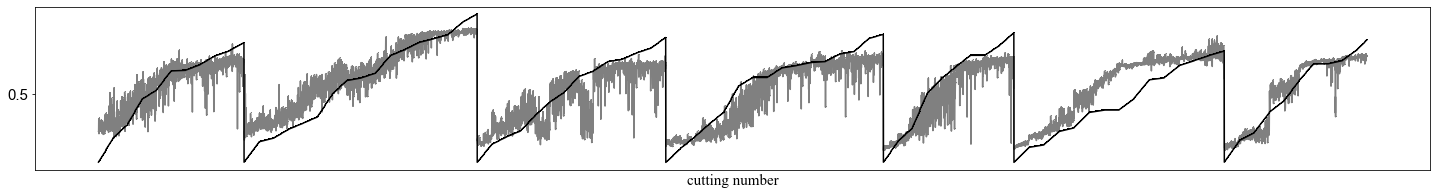

time1 =   7.8015265464782715 sample_num 1024
loss_test_avg 0.015580695
percent_test_avg 18.03991347551346 %


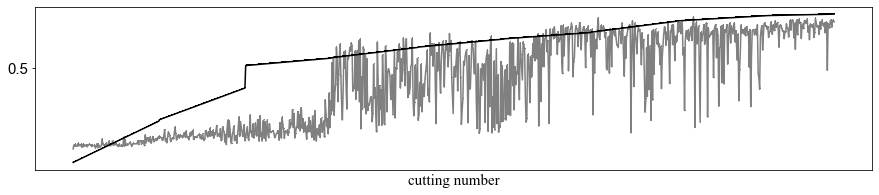

In [4]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 1
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/structure/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + '3_layer_LSTM.h5'
PHYSICINFOMED_SAVEPATH = DOCUMENT_RESULT_PATH + '3_layer_LSTM_result.npy'
    
load_flag = 1 ########################################1:重新加载模型，0：不加载##########################

if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 64
    SIGNAL_LENGTH_3 = 8

    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    BATCH_SIZE = 64

    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]

    predictor = keras.models.load_model(MODEL_LOAD_PATH)
################################################### 波形显示 ##################################################
fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
wear_pre_train = predictor.predict(X_train, batch_size = BATCH_SIZE)
print('wear_pre_train', np.shape(wear_pre_train))

axis = np.linspace(1, np.shape(wear_pre_train)[0], np.shape(wear_pre_train)[0])
print('loss_train_avg', np.mean(np.square(wear_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(wear_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
plt.figure(figsize=(25, 3))
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_train[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_train, marker = ',', color = 'black')
plt.show()

#test
time_start = time.time()
wear_pre_test = predictor.predict(X_test, batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(wear_pre_test)[0])

axis = np.linspace(1, np.shape(wear_pre_test)[0], np.shape(wear_pre_test)[0])
print('loss_test_avg', np.mean(np.square(wear_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(wear_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
plt.figure(figsize=(15, 3))
plt.xticks([])  #去掉纵坐标值
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
plt.yticks([0.0, 0.5, 1], fontproperties = 'Times New Roman', size = size)   
plt.plot(axis, wear_pre_test[:, 0], marker = ',', color = 'gray')
plt.plot(axis, Y_test, marker = ',', color = 'black')
plt.show()

np.save(PHYSICINFOMED_SAVEPATH, wear_pre_test[:, 0])

## mismatch period 1

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  
# LSTM + local attention + global attention

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/structure/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'mismatch_period_1.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 96
SIGNAL_LENGTH_3 = 6

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = SIGNAL_LENGTH_1//SIGNAL_LENGTH_2
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 2
    
##############################数据集读取########################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))

############################################################小波分析##########################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
#         print('self.u_query', np.shape(self.u_query))
#         print('key', np.shape(key))
        scores = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global(feature_local)
print('feature', np.shape(feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq], 
                         outputs=wear_predict, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local, att_distribution_global], 
                                      name = 'att_distribution_model')

predictor.summary()
#############################################模型训练#########################################################################

time_start = time.time()
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict', save_best_only=True, mode='max')

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
for i in range(PREDICTOR_TRAIN_BATCH1):
    adam = keras.optimizers.Adam(lr=0.001)
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
    adam = keras.optimizers.Adam(lr=0.0003)
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train],Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
    adam = keras.optimizers.Adam(lr=0.0001)
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9728, 1536, 3) -0.9293552041053772 0.8662327527999878
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6770890508760357
coeffs_highfreq_train (9728, 1536, 3) -0.6074406355435511 0.6436477411157987
coeffs_lowfreq_test (1088, 192, 3) -1.5425268591451757 1.6827855264342724
coeffs_highfreq_test (1088, 1536, 3) -0.8581441584885379 0.6740121754985141
feature_freq (64, 96, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 6, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 192, 3)]       0                                   

loss_train_avg 0.0015193862
percent_train_avg 6.726361811161041 %
mFPE 2.4353396892547607
MFPE 17.36616849899292


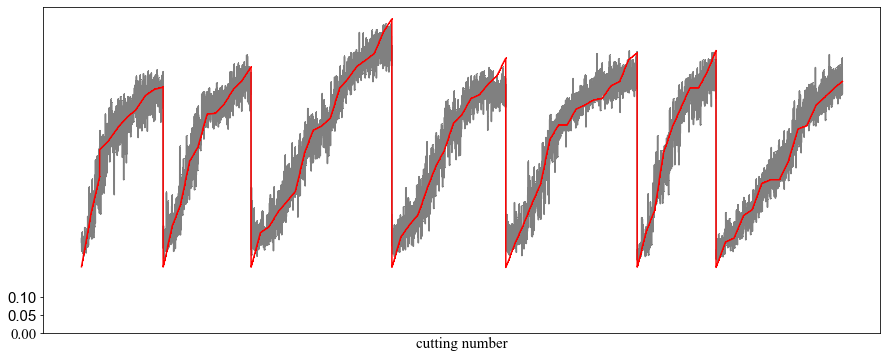

time1 =   2.222073554992676 sample_num 1088
loss_test_avg 0.003960173
percent_test_avg 10.928776860237122 %
mFPE 4.066730439662933
MFPE 20.91447114944458


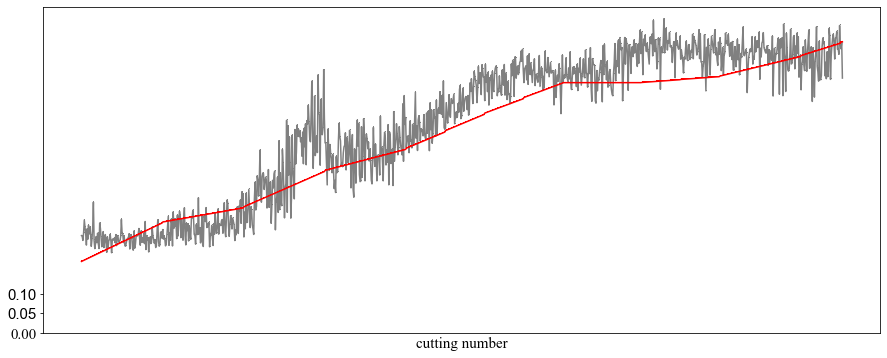

complete


In [8]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/structure/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'mismatch_period_1.h5'
RESULT_SAVEPATH = DOCUMENT_RESULT_PATH + 'mismatch_period_1_result.npy'


#画图，输出训练和测试曲线
load_flag = 1
if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 96
    SIGNAL_LENGTH_3 = 6
    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    ATTENTION_RANGE = SIGNAL_LENGTH_1//SIGNAL_LENGTH_2
    WEAR_SIZE = 1
    BATCH_SIZE = 64
    
    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    
    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]
    
    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
            super(temporal_Attention,self).build(input_shape)
        def call(self, key): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
    #         print('self.u_query', np.shape(self.u_query))
    #         print('key', np.shape(key))
            scores = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})


fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
Y_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train], batch_size = BATCH_SIZE)

axis = np.linspace(1, np.shape(Y_pre_train)[0], np.shape(Y_pre_train)[0])
print('loss_train_avg', np.mean(np.square(Y_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(Y_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
print('mFPE', np.mean(np.abs(Y_pre_train[:, 0] - Y_train))*80)
print('MFPE', np.max(np.abs(Y_pre_train[:, 0] - Y_train))*80)

plt.plot(axis, Y_pre_train,color = 'gray', marker = ',', label = 'predicted result')
plt.plot(axis, Y_train,'r',marker = ',',label = 'actual tool wear')
plt.xticks([])
plt.yticks([0.0, 0.05, 0.1], fontproperties = 'Times New Roman', size = size)   
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
# plt.savefig(DOCUMENT_RESULT_PATH + 'train_output.png', dpi = 300)
plt.show()

#test
time_start = time.time()
Y_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(Y_pre_test)[0])

axis = np.linspace(1, np.shape(Y_pre_test)[0], np.shape(Y_pre_test)[0])
print('loss_test_avg', np.mean(np.square(Y_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(Y_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
print('mFPE', np.mean(np.abs(Y_pre_test[:, 0] - Y_test))*80)
print('MFPE', np.max(np.abs(Y_pre_test[:, 0] - Y_test))*80)
        
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}
plt.plot(axis, Y_pre_test,color = 'gray', marker = ',', label = 'predicted result')
plt.plot(axis, Y_test,'r',marker = ',',label = 'actual tool wear')
plt.xticks([])
plt.yticks([0.0, 0.05, 0.1], fontproperties = 'Times New Roman', size = size)   
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.png', dpi = 300)
plt.show()

np.save(RESULT_SAVEPATH, Y_pre_test[:, 0])
print('complete')

## mismatch period 2

In [1]:
# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  
# LSTM + local attention + global attention

import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time
%load_ext tensorboard

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

file_index = 8
DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径
SUMMARY_PATH = 'logs'     #记录路径

DOCUMENT_RESULT_PATH = 'results/comparation/structure/'+str(file_index)+'/'
MODEL_SAVE_PATH = DOCUMENT_RESULT_PATH + 'mismatch_period_2.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 1536
SIGNAL_LENGTH_2 = 192
SIGNAL_LENGTH_3 = 12

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 3]
LOWFREQ_LSTM_SIZE = 13
LOWFREQ_FEATURE_SIZE = 15
ATTENTION_SIZE = 18

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 3]
HIGHFREQ_LSTM_SIZE = 15
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = SIGNAL_LENGTH_1//SIGNAL_LENGTH_2
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]//SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = SIGNAL_LENGTH_2//SIGNAL_LENGTH_3

LOCAL_DENSE_SIZE = 25
LOCAL_QUERY_SIZE = LOCAL_DENSE_SIZE

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 25
GLOBAL_DENSE_SIZE = 36
GLOBAL_QUERY_SIZE = GLOBAL_DENSE_SIZE

WEAR_DENSE_SIZE = 150
WEAR_SIZE = 1

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 2
    
##############################数据集读取########################################
# X_train [样本总量，样本长度，信号维度]
# Y_train [磨损标签，拟合磨损，主轴转速，进给量，轴向切削深度，单齿进给量，S，基于Taylor的剩余寿命]
X_train_set=np.load(TRAINDATA_LOADPATH)
Y_train_set = np.load(TRAINLABEL_LOADPATH)
Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
X_test_set=np.load(TESTDATA_LOADPATH)
Y_test_set = np.load(TESTLABEL_LOADPATH)
Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]

X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]

print('X_train', np.shape(X_train), np.min(X_train), np.max(X_train))
print('Y_train', np.shape(Y_train), np.min(Y_train), np.max(Y_train))
print('X_test', np.shape(X_test))
print('Y_test', np.shape(Y_test))

############################################################小波分析##########################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
coeffs_lowfreq_train = coeffs_train_force[0]
coeffs_highfreq_train = coeffs_train_force[1]
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train), np.min(coeffs_lowfreq_train), np.max(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train), np.min(coeffs_highfreq_train), np.max(coeffs_highfreq_train))

coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
coeffs_lowfreq_test = coeffs_test_force[0]
coeffs_highfreq_test = coeffs_test_force[1]
print('coeffs_lowfreq_test', np.shape(coeffs_lowfreq_test), np.min(coeffs_lowfreq_test), np.max(coeffs_lowfreq_test))
print('coeffs_highfreq_test', np.shape(coeffs_highfreq_test), np.min(coeffs_highfreq_test), np.max(coeffs_highfreq_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::ATTENTION_RANGE//8])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.BatchNormalization(trainable=False)(outputs)
#     outputs = layers.BatchNormalization()(outputs)
    outputs = layers.LeakyReLU()(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.LayerNormalization(axis = 1)(query)
    query = layers.LeakyReLU()(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向LSTM提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.LayerNormalization(axis = 1)(key)
    key = layers.LeakyReLU()(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.LayerNormalization(axis = 1)(value)
    value = layers.LeakyReLU()(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
#         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
        scores = tf.matmul(query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.matmul(distribution, value)
#         print('value_weighted1', np.shape(value_weighted))
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
#         print('value_weighted2', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape
    
class temporal_Attention(layers.Layer):
    # 将query，value和key拼接后输入，dot attention，便于timedistributed
    # https://blog.csdn.net/qq_37285386/article/details/101697758
    def __init__(self, **kwargs): #初始化方法
        super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
    def build(self, input_shape): #为Mylayer建立一个可训练的权重
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
#         print('self.u_query', np.shape(self.u_query))
#         print('key', np.shape(key))
        scores = tf.matmul(self.u_query, key, transpose_b=True)
#         print('scores', np.shape(scores))
        distribution = tf.nn.softmax(scores, axis = 2)
#         print('distribution', np.shape(distribution))
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
#         print('value_weighted1', np.shape(value_weighted))
        attention_distribution = tf.squeeze(distribution)
#         print('attention_distribution', np.shape(attention_distribution))
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

#这里将物理模型的输出与信号的平均值和方差作为提示特征
#低频
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
# input_lowfreq1 = layers.BatchNormalization()(input_lowfreq)
input_lowfreq1 = layers.BatchNormalization(trainable=False)(input_lowfreq)
#高频
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
input_highfreq1 = layers.BatchNormalization(trainable=False)(input_highfreq)
# input_highfreq1 = layers.BatchNormalization()(input_highfreq)

model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq1)
# feature_lowfreq = layers.Lambda(lambda x: x[:, ::6])(feature_lowfreq)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
# query = layers.Lambda(lambda x: x[:, ::6])(query)# 剔除冗余的 dual-scale 的输出。这里进行了降采样，可以优化
key, value = model_highfreq(input_highfreq1)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(value)
key = layers.Reshape([int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), -1, ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
# feature_highfreq = layers.BatchNormalization()(feature_highfreq)
feature_highfreq = layers.BatchNormalization(trainable=False)(feature_highfreq)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])
print('feature_freq', np.shape(feature_freq))

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

def globalLSTM_construct(input_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='inputs')
    x = layers.TimeDistributed(layers.Dense(dense_size))(inputs)
    x = layers.LayerNormalization(axis = 1)(x)
    x = layers.LeakyReLU()(x)
    outputs, att_distribution_global = temporal_Attention()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_global], name = name)
    return biLSTM_model

#local attention
biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
feature_local = layers.BatchNormalization(trainable=False)(feature_local)
# feature_local = layers.BatchNormalization()(feature_local)
print('feature_local', feature_local)

#global attention
biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
# biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature, att_distribution_global = biLSTM_global(feature_local)
print('feature', np.shape(feature))

#tool wear predict
x = layers.Dense(WEAR_DENSE_SIZE)(feature)
x = layers.BatchNormalization(trainable=False)(x)
# x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
wear_predict = layers.Dense(WEAR_SIZE, activation = 'sigmoid', name='wear_predict')(x)

predictor = models.Model(inputs=[input_lowfreq, input_highfreq], 
                         outputs=wear_predict, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local, att_distribution_global], 
                                      name = 'att_distribution_model')

predictor.summary()
#############################################模型训练#########################################################################

time_start = time.time()
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='wear_predict', save_best_only=True, mode='max')

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=SUMMARY_PATH, histogram_freq=1)
for i in range(PREDICTOR_TRAIN_BATCH1):
    adam = keras.optimizers.Adam(lr=0.001)
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
    adam = keras.optimizers.Adam(lr=0.0003)
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train],Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
    adam = keras.optimizers.Adam(lr=0.0001)
    predictor.compile(optimizer=adam, loss = 'mse', metrics = 'mape')
    history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                            validation_data = ([coeffs_lowfreq_test, coeffs_highfreq_test], Y_test), 
                            epochs=1,  shuffle=True, verbose=1, callbacks=[tensorboard_callback, checkpoint])
    
predictor.save(MODEL_SAVE_PATH)
print('time1 =  ', time.time()-time_start)

X_train (9728, 1536, 3) -0.9293552041053772 0.8662327527999878
Y_train (9728,) 0.18163076 0.87186223
X_test (1088, 1536, 3)
Y_test (1088,)
coeffs_lowfreq_train (9728, 192, 3) -1.6887109675302232 1.6770890508760357
coeffs_highfreq_train (9728, 1536, 3) -0.6074406355435511 0.6436477411157987
coeffs_lowfreq_test (1088, 192, 3) -1.5425268591451757 1.6827855264342724
coeffs_highfreq_test (1088, 1536, 3) -0.8581441584885379 0.6740121754985141
feature_freq (64, 192, 33)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 12, 25), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")
feature (64, 36)
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 192, 3)]       0                                 

loss_train_avg 0.001448504
percent_train_avg 6.609068810939789 %
mFPE 2.3587866127490997
MFPE 19.748787879943848


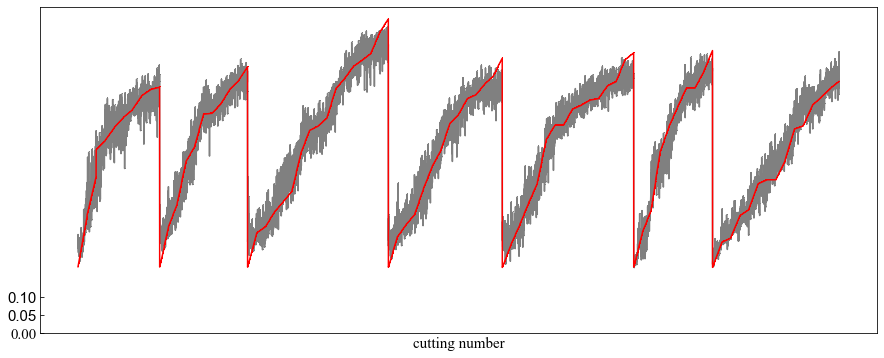

time1 =   2.479663610458374 sample_num 1088
loss_test_avg 0.0036929254
percent_test_avg 10.54033562541008 %
mFPE 3.845337927341461
MFPE 19.351987838745117


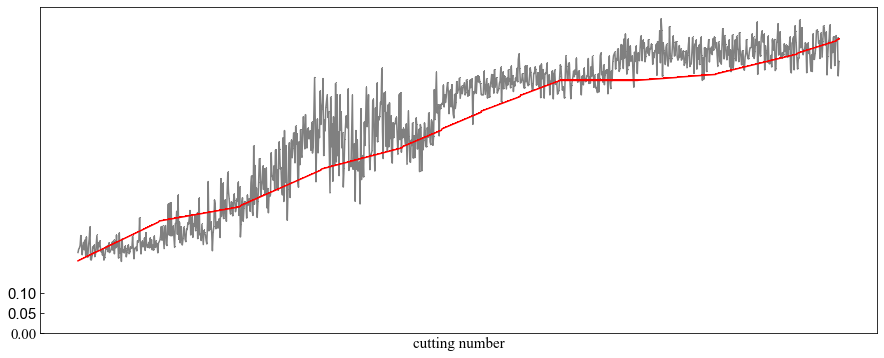

complete


In [9]:
#
import pywt
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend, regularizers
import time

file_index = 8

DOCUMENT_DATA_PATH = 'dataset/dataset'+str(file_index)+'/'
TRAINDATA_LOADPATH = DOCUMENT_DATA_PATH + 'train_data1.npy' #训练集数据读取路径
TRAINLABEL_LOADPATH = DOCUMENT_DATA_PATH + 'train_label1.npy' #训练集标签读取路径
TESTDATA_LOADPATH = DOCUMENT_DATA_PATH + 'test_data1.npy' #验证集数据读取路径
TESTLABEL_LOADPATH =  DOCUMENT_DATA_PATH + 'test_label1.npy' #验证集标签读取路径

DOCUMENT_RESULT_PATH = 'results/comparation/structure/'+str(file_index)+'/'
MODEL_LOAD_PATH = DOCUMENT_RESULT_PATH + 'mismatch_period_2.h5'
RESULT_SAVEPATH = DOCUMENT_RESULT_PATH + 'mismatch_period_2_result.npy'


#画图，输出训练和测试曲线
load_flag = 1
if load_flag == 1:
    #信号层级关系
    SIGNAL_LENGTH_1 = 1536
    SIGNAL_LENGTH_2 = 192
    SIGNAL_LENGTH_3 = 12
    #输入数据
    INPUT_SIZE = [SIGNAL_LENGTH_1, 3]  #[time_steps, input_vector]
    INPUT_NUM = INPUT_SIZE[1]
    SCALE_NUM_FORCE = 3 #小波分解级数
    WAVELET_HIGHFREQ = 'db2'
    WAVELET_LOWFREQ = 'db6'
    ATTENTION_RANGE = SIGNAL_LENGTH_1//SIGNAL_LENGTH_2
    WEAR_SIZE = 1
    BATCH_SIZE = 64
    
    X_train_set=np.load(TRAINDATA_LOADPATH)
    Y_train_set = np.load(TRAINLABEL_LOADPATH)
    Y_train_set[:, 0:2] = Y_train_set[:, 0:2]*10
    X_test_set=np.load(TESTDATA_LOADPATH)
    Y_test_set = np.load(TESTLABEL_LOADPATH)
    Y_test_set[:, 0:2] = Y_test_set[:, 0:2]*10

    #validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
    X_train = X_train_set[:(np.shape(X_train_set)[0]-np.shape(X_train_set)[0]%BATCH_SIZE)]
    Y_train = Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 0]# - Y_train_set[:(np.shape(Y_train_set)[0]-np.shape(Y_train_set)[0]%BATCH_SIZE), 1]
    X_test = X_test_set[:(np.shape(X_test_set)[0]-np.shape(X_test_set)[0]%BATCH_SIZE)]
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]# - Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 1]
    
    def wavelet_transform(data, scale_num):
        coeffs = np.arange(2).tolist()
        for j in range(np.shape(data)[2]):
            sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
            coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
            coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
            coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
            coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
    #         for i in range(1, scale_num+1):       #高频去噪
    #             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
            coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

            if j == 0:
                coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
                coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
            else:
                coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
                coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
        return coeffs

    coeffs_train_force = wavelet_transform(X_train, SCALE_NUM_FORCE)
    coeffs_lowfreq_train = coeffs_train_force[0]
    coeffs_highfreq_train = coeffs_train_force[1]
    coeffs_test_force = wavelet_transform(X_test, SCALE_NUM_FORCE)
    coeffs_lowfreq_test = coeffs_test_force[0]
    coeffs_highfreq_test = coeffs_test_force[1]
    
    class lowhigh_freq_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(lowhigh_freq_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            super(lowhigh_freq_Attention,self).build(input_shape)
        def call(self, x): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
            query = x[:, 0]
            query = tf.expand_dims(query, axis=1)
            value = x[:, 1:ATTENTION_RANGE+1]
            key = x[:, ATTENTION_RANGE+1:]
    #         print('query', np.shape(query), 'key', np.shape(key), 'value', np.shape(value))
            scores = tf.matmul(query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.matmul(distribution, value)
    #         print('value_weighted1', np.shape(value_weighted))
            value_weighted = tf.reduce_sum(value_weighted, axis=1)
    #         print('value_weighted2', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE) #这里是自己手动计算出来的output_shape

    class temporal_Attention(layers.Layer):
        # 将query，value和key拼接后输入，dot attention，便于timedistributed
        # https://blog.csdn.net/qq_37285386/article/details/101697758
        def __init__(self, **kwargs): #初始化方法
            super(temporal_Attention,self).__init__(**kwargs) #必须要的初始化自定义层
        def build(self, input_shape): #为Mylayer建立一个可训练的权重
            self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
            super(temporal_Attention,self).build(input_shape)
        def call(self, key): #call函数里就是定义了对x张量的计算图，且x只是一个形式，所以不能被事先定义
    #         print('self.u_query', np.shape(self.u_query))
    #         print('key', np.shape(key))
            scores = tf.matmul(self.u_query, key, transpose_b=True)
    #         print('scores', np.shape(scores))
            distribution = tf.nn.softmax(scores, axis = 2)
    #         print('distribution', np.shape(distribution))
            value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
    #         print('value_weighted1', np.shape(value_weighted))
            attention_distribution = tf.squeeze(distribution)
    #         print('attention_distribution', np.shape(attention_distribution))
            return value_weighted, attention_distribution
        def compute_output_shape(self,input_shape):
            return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])#这里是自己手动计算出来的output_shape

    predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                         'temporal_Attention':temporal_Attention})


fig_x = 15
fig_y = 6
size = 15
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}

#train
Y_pre_train = predictor.predict([coeffs_lowfreq_train, coeffs_highfreq_train], batch_size = BATCH_SIZE)

axis = np.linspace(1, np.shape(Y_pre_train)[0], np.shape(Y_pre_train)[0])
print('loss_train_avg', np.mean(np.square(Y_pre_train[:, 0] - Y_train)))
print('percent_train_avg', np.mean(np.abs(Y_pre_train[:, 0] - Y_train)/Y_train)*100, '%')
print('mFPE', np.mean(np.abs(Y_pre_train[:, 0] - Y_train))*80)
print('MFPE', np.max(np.abs(Y_pre_train[:, 0] - Y_train))*80)

plt.plot(axis, Y_pre_train,color = 'gray', marker = ',', label = 'predicted result')
plt.plot(axis, Y_train,'r',marker = ',',label = 'actual tool wear')
plt.xticks([])
plt.yticks([0.0, 0.05, 0.1], fontproperties = 'Times New Roman', size = size)   
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
# plt.savefig(DOCUMENT_RESULT_PATH + 'train_output.png', dpi = 300)
plt.show()

#test
time_start = time.time()
Y_pre_test = predictor.predict([coeffs_lowfreq_test, coeffs_highfreq_test], batch_size = BATCH_SIZE)
print('time1 =  ', time.time()-time_start, 'sample_num', np.shape(Y_pre_test)[0])

axis = np.linspace(1, np.shape(Y_pre_test)[0], np.shape(Y_pre_test)[0])
print('loss_test_avg', np.mean(np.square(Y_pre_test[:, 0] - Y_test)))
print('percent_test_avg', np.mean(np.abs(Y_pre_test[:, 0] - Y_test)/Y_test)*100, '%')
print('mFPE', np.mean(np.abs(Y_pre_test[:, 0] - Y_test))*80)
print('MFPE', np.max(np.abs(Y_pre_test[:, 0] - Y_test))*80)
        
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
font1 = {'family':'Times New Roman', 'weight':'normal', 'size':size}
plt.plot(axis, Y_pre_test,color = 'gray', marker = ',', label = 'predicted result')
plt.plot(axis, Y_test,'r',marker = ',',label = 'actual tool wear')
plt.xticks([])
plt.yticks([0.0, 0.05, 0.1], fontproperties = 'Times New Roman', size = size)   
plt.xlabel('cutting number', fontproperties = 'Times New Roman', size = size)
# plt.savefig(DOCUMENT_RESULT_PATH + 'test_output.png', dpi = 300)
plt.show()

np.save(RESULT_SAVEPATH, Y_pre_test[:, 0])
print('complete')

## 结果比较

1
mAPE
baseline:  7.344477623701096 %
multiLSTM:  18.03991347551346 %
mis1:  11.830335855484009 %
mis2:  7.50250518321991 %
mFPE
baseline:  3.5078936 um
multiLSTM:  9.352944 um
mis1:  5.793637 um
mis2:  3.732795 um
MFPE
baseline:  24.628918 um
multiLSTM:  36.12751 um
mis1:  30.335358 um
mis2:  20.39607 um


2
mAPE
baseline:  7.06934779882431 %
multiLSTM:  12.971813976764679 %
mis1:  9.487980604171753 %
mis2:  7.239648699760437 %
mFPE
baseline:  2.8182201 um
multiLSTM:  5.2387533 um
mis1:  3.9748387 um
mis2:  3.1369944 um
MFPE
baseline:  18.611862 um
multiLSTM:  37.845383 um
mis1:  17.301657 um
mis2:  14.3433895 um


3
mAPE
baseline:  11.177603155374527 %
multiLSTM:  23.819245398044586 %
mis1:  16.25547707080841 %
mis2:  12.310968339443207 %
mFPE
baseline:  5.492579 um
multiLSTM:  9.927317 um
mis1:  7.4545827 um
mis2:  5.981808 um
MFPE
baseline:  31.654444 um
multiLSTM:  40.621727 um
mis1:  37.948647 um
mis2:  32.180286 um


4
mAPE
baseline:  9.942427277565002 %
multiLSTM:  18.104875087

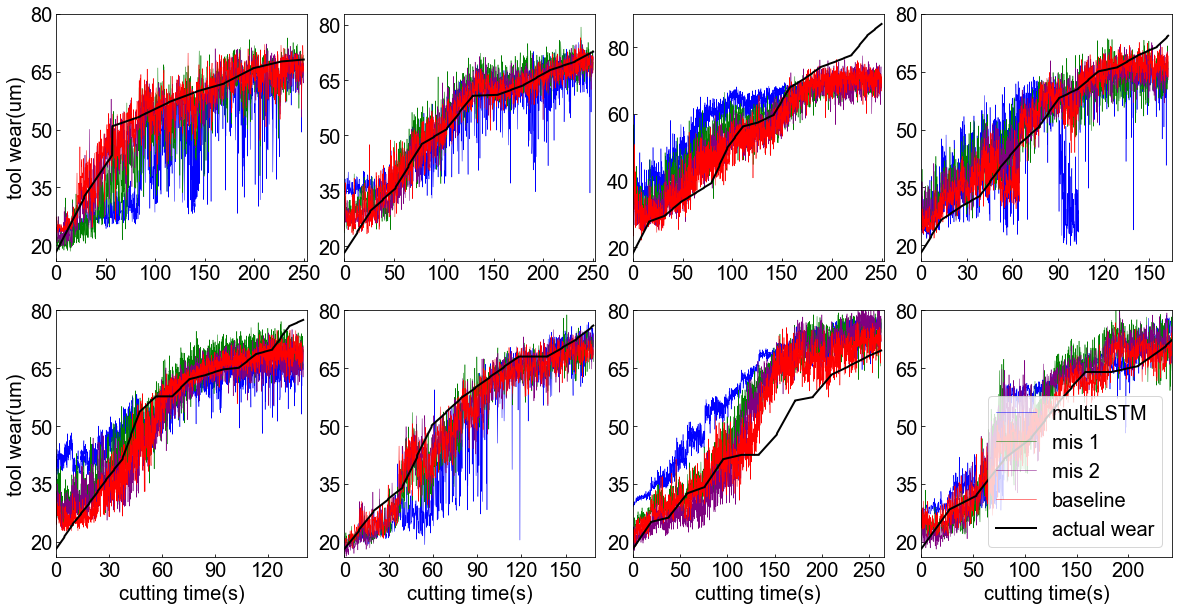

baseline: mAPE,  8.86628869920969 % mFPE 4.010923892259598 um MFPE 21.088023900985718 um
multiLSTM: mAPE,  19.100461900234222 % mFPE 8.219387948513031 um MFPE 34.81331729888916 um
mis1: mAPE,  12.607075273990631 % mFPE 5.644276201725006 um MFPE 24.9325053691864 um
mis2: mAPE,  10.67229164764285 % mFPE 4.8933278024196625 um MFPE 21.766646146774292 um


In [10]:
#leave-one-out输出

import pywt
import numpy as np
import matplotlib.pyplot as plt
import xlrd

DATADRIVEN_LOADPATH = ['results/prediction/1/datadriven_result.npy', 'results/prediction/2/datadriven_result.npy',
                       'results/prediction/3/datadriven_result.npy', 'results/prediction/4/datadriven_result.npy',
                       'results/prediction/5/datadriven_result.npy', 'results/prediction/6/datadriven_result.npy', 
                       'results/prediction/7/datadriven_result.npy', 'results/prediction/8/datadriven_result.npy']
DOCUMENT_RESULT_PATH = 'results/comparation/structure/'
MULTILAYER_LSTM_LOADPATH = [DOCUMENT_RESULT_PATH +'1/3_layer_LSTM_result.npy', DOCUMENT_RESULT_PATH +'2/3_layer_LSTM_result.npy', 
                            DOCUMENT_RESULT_PATH +'3/3_layer_LSTM_result.npy', DOCUMENT_RESULT_PATH +'4/3_layer_LSTM_result.npy', 
                            DOCUMENT_RESULT_PATH +'5/3_layer_LSTM_result.npy', DOCUMENT_RESULT_PATH +'6/3_layer_LSTM_result.npy', 
                            DOCUMENT_RESULT_PATH +'7/3_layer_LSTM_result.npy', DOCUMENT_RESULT_PATH +'8/3_layer_LSTM_result.npy']
MISMATCH_1_LOADPATH = [DOCUMENT_RESULT_PATH +'1/mismatch_period_1_result.npy', DOCUMENT_RESULT_PATH +'2/mismatch_period_1_result.npy', 
                       DOCUMENT_RESULT_PATH +'3/mismatch_period_1_result.npy', DOCUMENT_RESULT_PATH +'4/mismatch_period_1_result.npy', 
                       DOCUMENT_RESULT_PATH +'5/mismatch_period_1_result.npy', DOCUMENT_RESULT_PATH +'6/mismatch_period_1_result.npy', 
                       DOCUMENT_RESULT_PATH +'7/mismatch_period_1_result.npy', DOCUMENT_RESULT_PATH +'8/mismatch_period_1_result.npy']
MISMATCH_2_LOADPATH = [DOCUMENT_RESULT_PATH +'1/mismatch_period_2_result.npy', DOCUMENT_RESULT_PATH +'2/mismatch_period_2_result.npy', 
                       DOCUMENT_RESULT_PATH +'3/mismatch_period_2_result.npy', DOCUMENT_RESULT_PATH +'4/mismatch_period_2_result.npy', 
                       DOCUMENT_RESULT_PATH +'5/mismatch_period_2_result.npy', DOCUMENT_RESULT_PATH +'6/mismatch_period_2_result.npy', 
                       DOCUMENT_RESULT_PATH +'7/mismatch_period_2_result.npy', DOCUMENT_RESULT_PATH +'8/mismatch_period_2_result.npy']
LABEL_LOADPATH = ['dataset/dataset1/test_label1.npy', 'dataset/dataset2/test_label1.npy', 'dataset/dataset3/test_label1.npy', 
                  'dataset/dataset4/test_label1.npy', 'dataset/dataset5/test_label1.npy', 'dataset/dataset6/test_label1.npy', 
                  'dataset/dataset7/test_label1.npy', 'dataset/dataset8/test_label1.npy']

FIG_SAVEPATH = 'results/comparation/loss function/test_train_result.svg'
BATCH_SIZE = 64


CUTTING_TIME = [250, 250, 250, 162.5, 140, 168.75, 262.5, 250]
xlim = {'1': 253, '2': 252, '3': 252, '4': 165,
         '5': 142, '6': 170,'7': 265, '8': 242}
ylim = {'1': [16, 80], '2': [16, 83], '3': [16, 90], '4': [16, 80],
         '5': [16, 80], '6': [16, 80], '7': [16, 80], '8': [16, 80]}
xticks = {'1': [0, 50, 100, 150, 200, 250], '2': [0, 50, 100, 150, 200, 250],
         '3': [0, 50, 100, 150, 200, 250], '4': [0, 30, 60, 90, 120, 150],
         '5': [0, 30, 60, 90, 120, 150], '6': [0, 30, 60, 90, 120, 150],
         '7': [0, 50, 100, 150, 200, 250], '8': [0, 50, 100, 150, 200, 250]}
yticks = {'1': [20, 35, 50, 65, 80], '2': [20, 35, 50, 65, 80],
         '3': [20, 40, 60, 80, 100], '4': [20, 35, 50, 65, 80],
         '5': [20, 35, 50, 65, 80], '6': [20, 35, 50, 65, 80],
         '7': [20, 35, 50, 65, 80], '8': [20, 35, 50, 65, 80]}

x_y_label_size = 20
x_y_stick_size = 20
font = {'family':'Arial', 'weight':'normal', 'size':20}
plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.2)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

storage_list = np.zeros([8, 12])
for file_index in range(1, 9):
    #磨损标签
    Y_test_set = np.load(LABEL_LOADPATH[file_index-1])
    Y_test = Y_test_set[:(np.shape(Y_test_set)[0]-np.shape(Y_test_set)[0]%BATCH_SIZE), 0]*1000
    #信息融合模型结果
    baseline_result = np.load(DATADRIVEN_LOADPATH[file_index-1]) * 100
    multiLSTM_result = np.load(MULTILAYER_LSTM_LOADPATH[file_index-1]) * 100
    mis1_result = np.load(MISMATCH_1_LOADPATH[file_index-1]) * 100
    mis2_result = np.load(MISMATCH_2_LOADPATH[file_index-1]) * 100
    
    print(file_index)
    print('mAPE')
    baseline = np.mean(np.abs((baseline_result - Y_test)/Y_test))*100
    multiLSTM = np.mean(np.abs((multiLSTM_result - Y_test)/Y_test))*100
    mis1 = np.mean(np.abs((mis1_result - Y_test)/Y_test))*100
    mis2 = np.mean(np.abs((mis2_result - Y_test)/Y_test))*100
    storage_list[file_index-1, :4] = np.array([baseline, multiLSTM, mis1, mis2])
    print('baseline: ', baseline, '%')
    print('multiLSTM: ', multiLSTM, '%')
    print('mis1: ', mis1, '%')
    print('mis2: ', mis2, '%')
    
    print('mFPE')
    baseline = np.mean(np.abs(baseline_result - Y_test))
    multiLSTM = np.mean(np.abs(multiLSTM_result - Y_test))
    mis1 = np.mean(np.abs(mis1_result - Y_test))
    mis2 = np.mean(np.abs(mis2_result - Y_test))
    storage_list[file_index-1, 4:8] = np.array([baseline, multiLSTM, mis1, mis2])
    print('baseline: ', baseline, 'um')
    print('multiLSTM: ', multiLSTM, 'um')
    print('mis1: ', mis1, 'um')
    print('mis2: ', mis2, 'um')
    
    print('MFPE')
    baseline = np.max(np.abs(baseline_result - Y_test))
    multiLSTM = np.max(np.abs(multiLSTM_result - Y_test))
    mis1 = np.max(np.abs(mis1_result - Y_test))
    mis2 = np.max(np.abs(mis2_result - Y_test))
    storage_list[file_index-1, 8:12] = np.array([baseline, multiLSTM, mis1, mis2])
    print('baseline: ', baseline, 'um')
    print('multiLSTM: ', multiLSTM, 'um')
    print('mis1: ', mis1, 'um')
    print('mis2: ', mis2, 'um')
    print('\n')

    plt.subplot(2,4,file_index)
    axis = np.linspace(0, CUTTING_TIME[file_index-1], num=np.shape(Y_test)[0]+1)[1:]
    plt.plot(axis, multiLSTM_result, linewidth=0.5, color='blue', label = 'multiLSTM')
    plt.plot(axis, mis1_result, linewidth=0.5, color='green', label = 'mis 1')
    plt.plot(axis, mis2_result, linewidth=0.5, color='purple', label = 'mis 2')
    plt.plot(axis, baseline_result,linewidth=0.5, color='red', label = 'baseline')
    plt.plot(axis, Y_test, linewidth=2, color='black', label = 'actual wear')
    
    if file_index-1 == 4 or file_index-1 == 5 or file_index-1 == 6 or file_index-1 == 7:
        plt.xlabel('cutting time(s)', font)
    if file_index-1 == 0 or file_index-1 == 4:
        plt.ylabel('tool wear(um)', font)
    plt.tick_params(labelsize=x_y_label_size) #坐标及刻度设置
    plt.xticks(xticks[str(file_index)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.yticks(yticks[str(file_index)], fontproperties = 'Arial', size = x_y_stick_size)
    plt.xlim(xmin=0, xmax=xlim[str(file_index)]), plt.ylim(ymin=ylim[str(file_index)][0], ymax=ylim[str(file_index)][1])
    if file_index-1 == 7:
        plt.legend(prop = font)
plt.savefig(FIG_SAVEPATH, bbox_inches='tight')#无空白边界
plt.show()


averge_index = np.mean(storage_list, axis = 0)
print('baseline: mAPE, ', averge_index[0], '%', 'mFPE', averge_index[4], 'um', 'MFPE', averge_index[8], 'um')
print('multiLSTM: mAPE, ', averge_index[1], '%', 'mFPE', averge_index[5], 'um', 'MFPE', averge_index[9], 'um')
print('mis1: mAPE, ', averge_index[2], '%', 'mFPE', averge_index[6], 'um', 'MFPE', averge_index[10], 'um')
print('mis2: mAPE, ', averge_index[3], '%', 'mFPE', averge_index[7], 'um', 'MFPE', averge_index[11], 'um')